In [1]:
# importing required modules
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import scipy.stats
from scipy.stats import loguniform
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression,SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as gbm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Read data from the CSV file 'filtered_df.csv' into a pandas DataFrame.
# Set the first column as the index column (index_col=0).
data = pd.read_csv('filtered_df.csv', index_col=0)

In [3]:
data

,Longitude,Latitude,TBV89,TBV36,TBH89,TBH36,Distance,Echo_top_height,Reflectivity
0,28.962635,-80.154785,172.409996,168.259996,158.179996,145.139997,0.000743,1576.0,0.25
1,28.915127,-80.149429,171.099996,166.969996,155.199997,142.529997,0.000649,1576.0,0.52
2,28.867922,-80.144035,171.099996,166.969996,155.199997,142.529997,0.000569,1575.0,0.30
3,28.584988,-80.111633,172.099996,169.559996,157.409996,144.709997,0.000503,2050.0,-0.37
4,28.538109,-80.106201,176.409996,171.699996,159.929996,147.119997,0.000448,2050.0,0.67
...,...,...,...,...,...,...,...,...,...
42168,136.274826,5.506119,260.689994,244.379995,251.179994,206.319995,0.000455,4023.0,-0.77
42169,136.272766,5.496449,260.689994,244.379995,251.179994,206.319995,0.000615,3544.0,1.20
42170,135.108414,0.023427,281.489994,236.369995,269.679994,182.579996,0.000679,344.0,25.72
42171,135.106354,0.013758,281.489994,236.369995,269.679994,182.579996,0.000521,345.0,25.42


## Splitting data into predictor and target variables

In [4]:
# Splitting data into predictor and target variables
X = data[['TBV89','TBV36','TBH89','TBH36','Reflectivity']]
y = data[['Echo_top_height']]

In [5]:
# Split the data into training and testing sets using train_test_split function
# test_size=0.3 specifies that 30% of the data will be used for testing, and 70% for training.
# random_state=42 sets the random seed for reproducibility of the split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# Reset the index of the DataFrames X_train, X_test, y_train, and y_test to be consecutive integers,
# and modify the DataFrames in place (drop=True removes the old index).
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [7]:
# Flatten the target variable arrays y_train and y_test to be 1-dimensional arrays using ravel().
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [8]:
# Display the shapes of the arrays X_train, X_test, y_train, and y_test.
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29521, 5), (12652, 5), (29521,), (12652,))

## Baseline model

In [9]:
# Create a dummy regressor using median strategy.
dummy_reg = DummyRegressor(strategy='median')

# Fit the dummy regressor using the training data.
dummy_reg.fit(X_train, y_train)

# Predict the target variable on the test data using the trained dummy regressor.
y_pred = dummy_reg.predict(X_test)

# Calculate and print the Root Mean Squared Error (RMSE) between the predicted and actual target values.
print("Dummy RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Calculate and print the Mean Absolute Error (MAE) between the predicted and actual target values.
print("MAE:", mean_absolute_error(y_test, y_pred))

# Calculate and print the R-squared (r2) score between the predicted and actual target values.
print("r2:", r2_score(y_test, y_pred))


Dummy RMSE: 3735.768764103629
MAE: 2959.4567657287384
r2: -0.0505944196038175


## To evaluate the performance of a model on a dataset, we need to measure how well the predictions made by the model match the observed data.
## We will use KFold for cross-validation

In [10]:
# Create a K-Fold cross-validator object with 5 folds.
# K-Fold cross-validation splits the data into 5 equally sized folds for training and testing.
# 'shuffle=True' shuffles the data before splitting to ensure randomness.
# 'random_state=42' sets the random seed for reproducibility of the shuffle.
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 1. Decision tree based models
### Decision tree based models are not sensitive to multicolinearity, therefore we don't need to get rid of predictor variables that have high correlation.
### Decison tree based models do not require feature scaling to be performed as they are not sensitive to the the variance in the data.

## 1.1. Random Forest Regressor

### We will use RandomizedSeach instead of GridSearch as it shows similar accuracy but is much faster

In [11]:
# Define a dictionary 'rf_parameters' that holds various hyperparameters for a Random Forest model.
# The hyperparameters are used for hyperparameter tuning to find the best combination of parameters.
# 'bootstrap': Whether to bootstrap samples when building trees.
# 'criterion': The function to measure the quality of a split.
# 'max_depth': The maximum depth of the trees.
# 'max_features': The number of features to consider when looking for the best split.
# 'min_samples_leaf': The minimum number of samples required to be at a leaf node.
# 'min_samples_split': The minimum number of samples required to split an internal node.
# 'n_estimators': The number of trees in the forest.
rf_parameters = {'bootstrap': [True, False],
                 'criterion':['squared_error', 'absolute_error', 'poisson'],
                 'max_depth': [10, 20, 30], #40, 50, 60, 70, 80, 90, 100, None],
                 'max_features': ['auto','sqrt','log2',None],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [10,100,200]} #400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [12]:
# Create a Random Forest Regressor model with a fixed random state for reproducibility.
rf_model = RandomForestRegressor(random_state=42)
# Use RandomizedSearchCV to perform hyperparameter tuning for the Random Forest model.
# 'param_distributions' specifies the dictionary of hyperparameter options to search through.
# 'cv' is the K-Fold cross-validator for cross-validation during the search.
# 'scoring' is the scoring metric used to evaluate the performance of different parameter combinations.
rf_reg = RandomizedSearchCV(rf_model, param_distributions=rf_parameters,
                            cv=cv, scoring='neg_root_mean_squared_error')

In [14]:
# Fit the RandomizedSearchCV model on the training data to find the best hyperparameters.
rf_reg.fit(X_train, y_train)

In [ ]:
# print('The best RMSE score is', rf_reg.best_score_,'with following best parameters',rf_reg.best_params_)

In [15]:
# Create the model with the best parameters
rf_model = RandomForestRegressor(n_estimators = 100, min_samples_split = 2,
                                 min_samples_leaf = 1, max_features = 'auto',
                                 max_depth = 30, criterion = 'absolute_error',
                                 bootstrap=True, random_state=42)

In [16]:
# Fit optimal model with training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=30, random_state=42)

In [17]:
# Make predictions on the test data using the trained model
y_pred = rf_model.predict(X_test)

## Evaluation Metrics
### We will evaluate the performance of the model using two metrics - R-squared value and Root Mean Squared Error (RMSE).

### R-squared values range from 0 to 1 and are commonly stated as percentages. It is a statistical measure that represents the proportion of the variance for a target variable that is explained by the independent variables. The other commonly used metric for regression problems is RMSE, that measures the average magnitude of the residuals or error. We will be using both these metrics to evaluate the model performance.

### Ideally, lower RMSE and higher R-squared values are indicative of a good model.

In [18]:
# Calculate and print the Root Mean Squared Error (RMSE) between the actual and predicted values.
# 'mean_squared_error' is used with 'squared=False' to get the RMSE value directly.
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Calculate and print the Mean Absolute Error (MAE) between the actual and predicted values.
print("MAE:", mean_absolute_error(y_test, y_pred))

# Calculate and print the R-squared (coefficient of determination) value between the actual and predicted values.
# R-squared measures the proportion of variance in the target variable explained by the model.
print("R-squared:", r2_score(y_test, y_pred))

RMSE: 1353.976744336331
MAE: 749.1977960006324
R-squared: 0.8619941403400329


/Users/yuliya/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


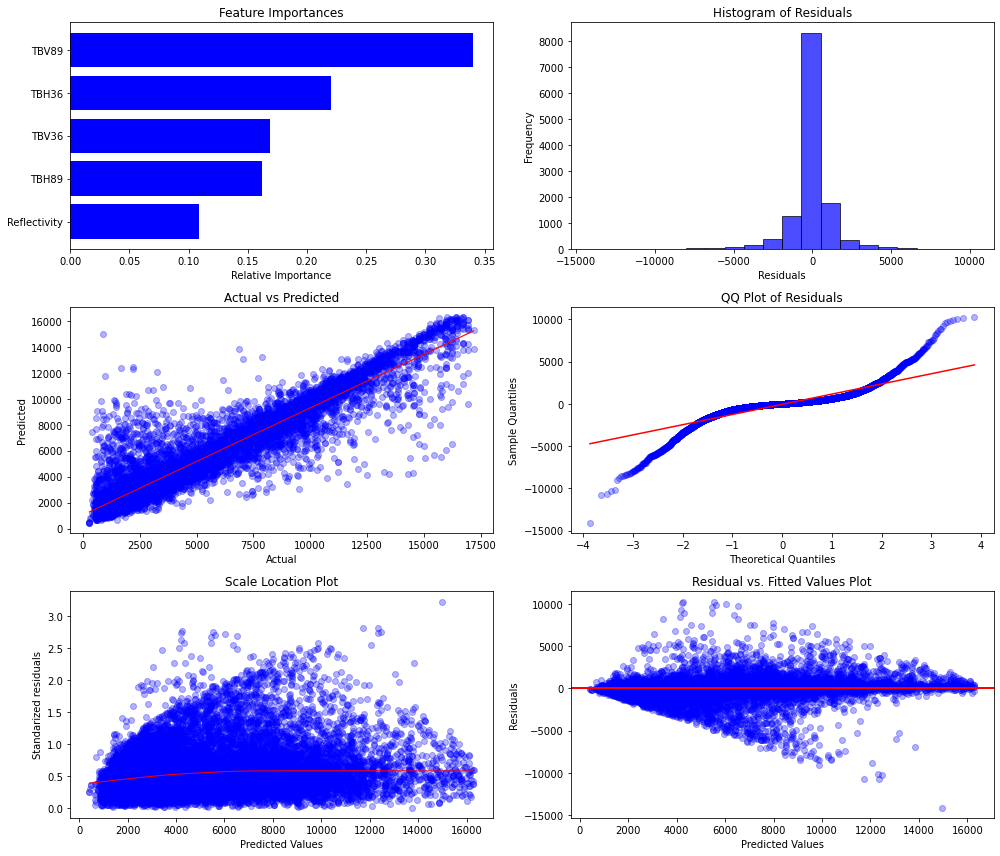

In [19]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

# Get the feature importances from the trained Random Forest model and visualize them using a horizontal bar chart
features = X.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

# Plot the data on the top-left subplot (row=0, col=0)
axes[0, 0].barh(range(len(indices)), importances[indices], color='blue', align='center')  
axes[0, 0].set_yticks(range(len(indices)))
axes[0, 0].set_yticklabels([features[i] for i in indices])
axes[0, 0].set_xlabel('Relative Importance')
axes[0, 0].set_title('Feature Importances')

# Plot data on the top-right subplot (row=0, col=1): Histogram of Residuals
residuals = y_test - y_pred
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='blue')  
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of Residuals')

# QQ Plot of Residuals
stats.probplot(residuals, plot=axes[1, 1])
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')
axes[1, 1].set_title('QQ Plot of Residuals')
axes[1, 1].get_lines()[0].set_alpha(0.3)

# Actual vs. Predicted Plot
plotDa = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
sns.regplot(x='y_test', y='y_pred', data=plotDa, fit_reg=True,
            scatter_kws={'color': 'blue', 'alpha': 0.3},line_kws={'color': 'red', 'lw': 1}, ax=axes[1, 0])
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title('Actual vs Predicted')

# Scale Location Plot
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
spread = np.sqrt(np.abs(standardized_residuals))
sns.regplot(y_pred, spread,
            scatter=True,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1}, color='blue',scatter_kws={'alpha': 0.3},ax=axes[2, 0])
axes[2, 0].set_xlabel('Predicted Values')
axes[2, 0].set_ylabel('Standarized residuals')
axes[2, 0].set_title('Scale Location Plot')

# Residual vs. Fitted Values Plot
axes[2, 1].scatter(y_pred, residuals, alpha=0.3, color='blue')  
axes[2, 1].axhline(y=0, color='red', linewidth=2)  
axes[2, 1].set_xlabel('Predicted Values')
axes[2, 1].set_ylabel('Residuals')
axes[2, 1].set_title('Residual vs. Fitted Values Plot')

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

## 1.2. XGBoost Regressor

In [20]:
# Define a dictionary 'xgb_parameters' that holds various hyperparameters for an XGBoost regression model.
# These hyperparameters will be used for hyperparameter tuning to find the best combination of parameters.
# 'learning_rate': The step size shrinkage used to prevent overfitting.
# 'max_depth': The maximum depth of a tree (controls the complexity of the model).
# 'min_child_weight': The minimum sum of instance weight needed in a child node.
# 'subsample': The fraction of samples used for training each tree.
# 'colsample_bytree': The fraction of features used for training each tree.
# 'n_estimators': The number of boosting rounds.
# 'objective': The loss function used during training ('reg:squarederror' for regression tasks).
xgb_parameters = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 5, 7, 10, 12, 14, 16, 18],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.1, 0.3, 0.5, 0.7, 0.9],
    'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9],
    'n_estimators': [50, 100, 200, 500],
    'objective': ['reg:squarederror']
}

In [21]:
# Create an XGBoost Regressor model with specific settings and a fixed random seed for reproducibility.
xgb_model = xgb.XGBRegressor(verbosity=0, seed=42)

# Use RandomizedSearchCV to perform hyperparameter tuning for the XGBoost model.
xgb_reg = RandomizedSearchCV(xgb_model, param_distributions=xgb_parameters,
                             cv=cv, scoring='neg_root_mean_squared_error')

In [ ]:
# Fit the XGBoost Regressor model using RandomizedSearchCV on the training data to find the best hyperparameters.
xgb_reg.fit(X_train, y_train)

In [ ]:
#print('The best RMSE score is', xgb_reg.best_score_,'with following best parameters',xgb_reg.best_params_)

In [22]:
# Create an XGBoost Regressor model with the best hyperparameters.
xgb_model = xgb.XGBRegressor(subsample=0.7,objective='reg:squarederror',
                        n_estimators = 200, min_child_weight=2,
                         max_depth=14,learning_rate=0.2,
                         colsample_bytree=0.5,seed=42)

In [23]:
# Fit the XGBoost Regressor model on the training data
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
# Make predictions using the trained XGBoost Regressor model on the test data
y_pred = xgb_model.predict(X_test)

In [25]:
# Calculate and print the Root Mean Squared Error (RMSE) between the actual and predicted values.
# 'mean_squared_error' is used with 'squared=False' to get the RMSE value directly.
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Calculate and print the Mean Absolute Error (MAE) between the actual and predicted values.
print("MAE:", mean_absolute_error(y_test, y_pred))

# Calculate and print the R-squared (coefficient of determination) value between the actual and predicted values.
# R-squared measures the proportion of variance in the target variable explained by the model.
print("R-squared:", r2_score(y_test, y_pred))

RMSE: 1158.622079407399
MAE: 738.4459335361521
R-squared: 0.8989447880076987


/Users/yuliya/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


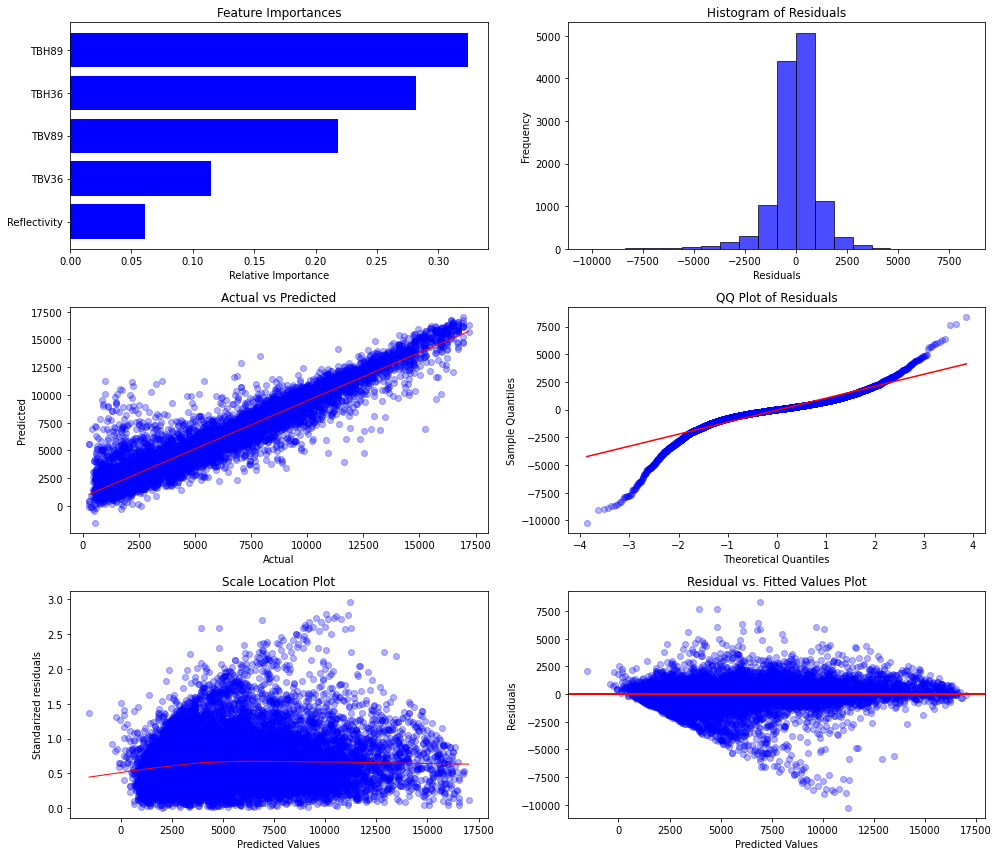

In [26]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

# Get the feature importances from the trained Random Forest model and visualize them using a horizontal bar chart
features = X.columns
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

# Plot the data on the top-left subplot (row=0, col=0)
axes[0, 0].barh(range(len(indices)), importances[indices], color='blue', align='center')  
axes[0, 0].set_yticks(range(len(indices)))
axes[0, 0].set_yticklabels([features[i] for i in indices])
axes[0, 0].set_xlabel('Relative Importance')
axes[0, 0].set_title('Feature Importances')

# Plot data on the top-right subplot (row=0, col=1): Histogram of Residuals
residuals = y_test - y_pred
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='blue')  
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of Residuals')

# QQ Plot of Residuals
stats.probplot(residuals, plot=axes[1, 1])
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')
axes[1, 1].set_title('QQ Plot of Residuals')
axes[1, 1].get_lines()[0].set_alpha(0.3)

# Actual vs. Predicted Plot
plotDa = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
sns.regplot(x='y_test', y='y_pred', data=plotDa, fit_reg=True,
            scatter_kws={'color': 'blue', 'alpha': 0.3},line_kws={'color': 'red', 'lw': 1}, ax=axes[1, 0])
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title('Actual vs Predicted')

# Scale Location Plot
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
spread = np.sqrt(np.abs(standardized_residuals))
sns.regplot(y_pred, spread,
            scatter=True,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1}, color='blue',scatter_kws={'alpha': 0.3},ax=axes[2, 0])
axes[2, 0].set_xlabel('Predicted Values')
axes[2, 0].set_ylabel('Standarized residuals')
axes[2, 0].set_title('Scale Location Plot')

# Residual vs. Fitted Values Plot
axes[2, 1].scatter(y_pred, residuals, alpha=0.3, color='blue')  
axes[2, 1].axhline(y=0, color='red', linewidth=2)  
axes[2, 1].set_xlabel('Predicted Values')
axes[2, 1].set_ylabel('Residuals')
axes[2, 1].set_title('Residual vs. Fitted Values Plot')

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

## 1.3. Light GBM

In [27]:
# Define hyperparameter search space for Gradient Boosting Machine (GBM) using a dictionary
gbm_parameters = {'learning_rate': np.arange(0.01, 1.0,0.1),
                'num_leaves': np.arange(1, 100,10),
                'feature_fraction': np.arange(0.1, 1,0.1),
                'bagging_fraction': np.arange(0.1, 1,0.1),
                'max_depth': np.arange(1, 30,5),
                'max_bin':np.arange(1,100,10),
                'min_data_in_leaf': np.arange(1, 100,10),
                'min_sum_hessian_in_leaf':np.arange(0,100,10),
                'subsample': np.arange(0.01, 1.0,0.1)}

In [28]:
# Create a Gradient Boosting regressor model
gbm_model = gbm.LGBMRegressor()

# Perform Randomized Search Cross-Validation to find the best hyperparameters for the GBM model
# using the defined hyperparameter search space 'gbm_parameters'
# scoring: Evaluation metric to optimize (negative root mean squared error in this case)
gbm_reg = RandomizedSearchCV(gbm_model, param_distributions=gbm_parameters,
                            cv=cv, scoring='neg_root_mean_squared_error')

In [ ]:
# Fit the GBM regressor to the training data
gbm_reg.fit(X_train, y_train)

In [ ]:
#print('The best RMSE score is', gbm_reg.best_score_,'with following best parameters',gbm_reg.best_params_)

In [29]:
# Create an LGBM Regressor model with the best hyperparameters
gbm_model = gbm.LGBMRegressor(num_leaves=90,
                              min_data_in_leaf = 19,
                              max_depth=17,
                              learning_rate= 0.4,
                              num_iterations = 1100,
                              boosting='dart',
                              lambda_l1 = 10)    

In [30]:
# Fit the LGBM regressor to the training data
gbm_model.fit(X_train, y_train)
# Make predictions using the trained LGBM Regressor model on the test data
y_pred = gbm_model.predict(X_test)

/Users/yuliya/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10


In [31]:
# Calculate and print the Root Mean Squared Error (RMSE) between the actual and predicted values.
# 'mean_squared_error' is used with 'squared=False' to get the RMSE value directly.
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Calculate and print the Mean Absolute Error (MAE) between the actual and predicted values.
print("MAE:", mean_absolute_error(y_test, y_pred))

# Calculate and print the R-squared (coefficient of determination) value between the actual and predicted values.
# R-squared measures the proportion of variance in the target variable explained by the model.
print("R-squared:", r2_score(y_test, y_pred))

RMSE: 1247.2110905842028
MAE: 797.7384448807671
R-squared: 0.8829004988986173


/Users/yuliya/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


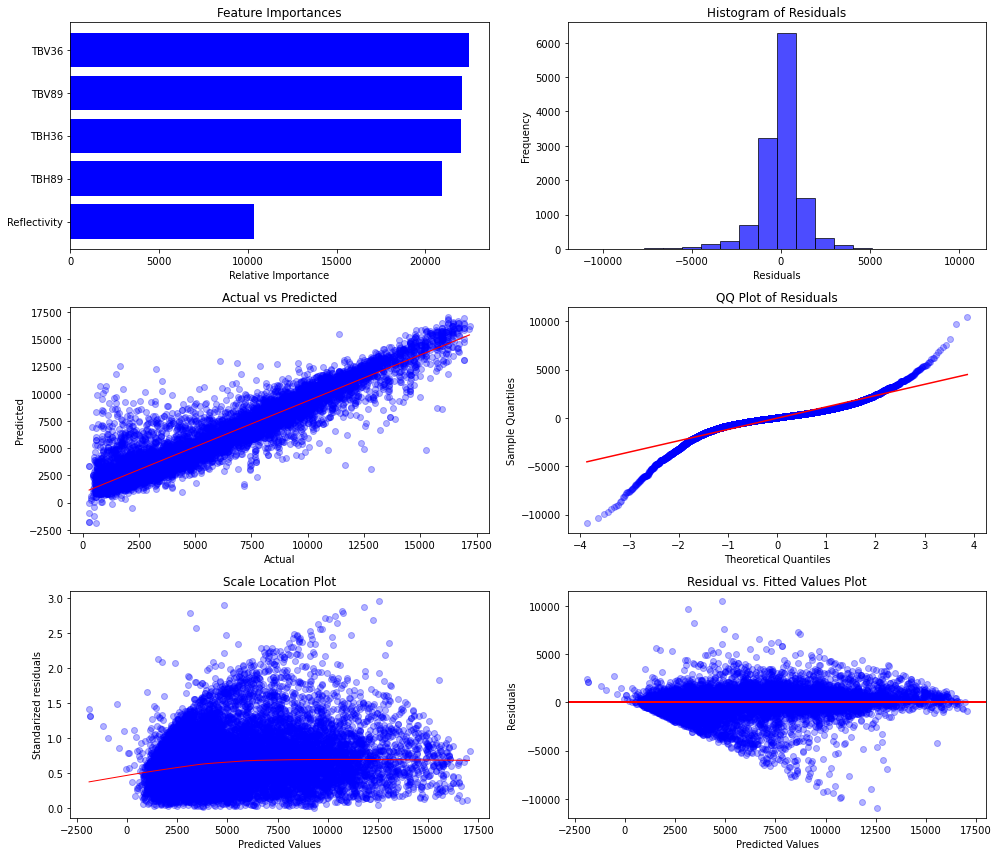

In [32]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

# Get the feature importances from the trained Random Forest model and visualize them using a horizontal bar chart
features = X.columns
importances = gbm_model.feature_importances_
indices = np.argsort(importances)

# Plot the data on the top-left subplot (row=0, col=0)
axes[0, 0].barh(range(len(indices)), importances[indices], color='blue', align='center')  
axes[0, 0].set_yticks(range(len(indices)))
axes[0, 0].set_yticklabels([features[i] for i in indices])
axes[0, 0].set_xlabel('Relative Importance')
axes[0, 0].set_title('Feature Importances')

# Plot data on the top-right subplot (row=0, col=1): Histogram of Residuals
residuals = y_test - y_pred
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='blue')  
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of Residuals')

# QQ Plot of Residuals
stats.probplot(residuals, plot=axes[1, 1])
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')
axes[1, 1].set_title('QQ Plot of Residuals')
axes[1, 1].get_lines()[0].set_alpha(0.3)

# Actual vs. Predicted Plot
plotDa = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
sns.regplot(x='y_test', y='y_pred', data=plotDa, fit_reg=True,
            scatter_kws={'color': 'blue', 'alpha': 0.3},line_kws={'color': 'red', 'lw': 1}, ax=axes[1, 0])
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title('Actual vs Predicted')

# Scale Location Plot
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
spread = np.sqrt(np.abs(standardized_residuals))
sns.regplot(y_pred, spread,
            scatter=True,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1}, color='blue',scatter_kws={'alpha': 0.3},ax=axes[2, 0])
axes[2, 0].set_xlabel('Predicted Values')
axes[2, 0].set_ylabel('Standarized residuals')
axes[2, 0].set_title('Scale Location Plot')

# Residual vs. Fitted Values Plot
axes[2, 1].scatter(y_pred, residuals, alpha=0.3, color='blue')  
axes[2, 1].axhline(y=0, color='red', linewidth=2)  
axes[2, 1].set_xlabel('Predicted Values')
axes[2, 1].set_ylabel('Residuals')
axes[2, 1].set_title('Residual vs. Fitted Values Plot')

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

# All linear regression models tested showed much worse performance compared to decision tree based models probably due to high multicolinearity between predictor variables, precence of outliers as well as skewed distribution of predictor variables. Steps taken (normalization, scaling, PCA) did not significantly improve performance evaluation metrics.